<a href="https://colab.research.google.com/github/56sarager/Graphene-Classification/blob/main/Graphene_Classifcation_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Structure

In [ ]:
#Zip file of images downloaded from Google Drive and uploaded to colab (folder.zip)
import zipfile
import os

def unzip_file(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Extracted all files to {extract_to}")

zip_file_path = '/content/folder.zip'
extraction_directory = 'Graphene Clean Dataset'
unzip_file(zip_file_path, extraction_directory)

Extracted all files to Graphene Clean Dataset


In [ ]:
import os
import shutil
import random

# Set paths
original_folder = '/content/Graphene Clean Dataset/Graphene Clean Dataset'
train_folder = '/content/Dataset/train'
test_folder = '/content/Dataset/test'

# Create the necessary directories
os.makedirs(os.path.join(train_folder, 'graphene'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'non_graphene'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'graphene'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'non_graphene'), exist_ok=True)

# Get list of all files in the original folder
all_files = os.listdir(original_folder)

# Separate graphene flakes and non-graphene images
graphene_files = [f for f in all_files if f.endswith('f.jpg')]
non_graphene_files = [f for f in all_files if not f.endswith('f.jpg')]

# Shuffle the files for randomness
random.shuffle(graphene_files)
random.shuffle(non_graphene_files)

if len(graphene_files) < 50 or len(non_graphene_files) < 50:
    raise ValueError("Not enough images in one or both categories to create a balanced test set of 50 each.")

# Split the graphene files into training and testing
test_graphene_files = graphene_files[:50]
train_graphene_files = graphene_files[50:]

# Split the non-graphene files into training and testing
test_non_graphene_files = non_graphene_files[:50]
train_non_graphene_files = non_graphene_files[50:]

def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        src_path = os.path.join(src_folder, file)
        dest_path = os.path.join(dest_folder, file)

        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {src_path} does not exist.")

move_files(train_graphene_files, original_folder, os.path.join(train_folder, 'graphene'))
move_files(train_non_graphene_files, original_folder, os.path.join(train_folder, 'non_graphene'))

move_files(test_graphene_files, original_folder, os.path.join(test_folder, 'graphene'))
move_files(test_non_graphene_files, original_folder, os.path.join(test_folder, 'non_graphene'))

print("Dataset split completed!")

Dataset split completed!


#Resnet50

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, auc, confusion_matrix
import time

# Set paths
train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization based on ImageNet dataset
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the last layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)  # Move to GPU and convert labels to float
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)  # Remove the extra dimension from outputs
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluating the model and calculating metrics
model.eval()
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs.squeeze())
        predicted = (probabilities > 0.5).float()  # Sigmoid for binary classification
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

end_time = time.time()
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Print the runtime
runtime = end_time - start_time
print(f'Evaluation Runtime: {runtime:.2f} seconds')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
torch.save(model.state_dict(), 'graphene_classifier_resnet.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


Epoch [1/10], Loss: 0.0337
Epoch [2/10], Loss: 0.0155


#AlexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.0MB/s]


Epoch [1/20], Loss: 0.0332, F1 Score: 0.99
Epoch [2/20], Loss: 0.0041, F1 Score: 0.99
Epoch [3/20], Loss: 0.0015, F1 Score: 0.96
Epoch [4/20], Loss: 0.0012, F1 Score: 0.97
Epoch [5/20], Loss: 0.0009, F1 Score: 0.99
Epoch [6/20], Loss: 0.0004, F1 Score: 0.97
Early stopping triggered.
Best F1 Score: 0.99
Total Runtime: 115.08 seconds


<ipython-input-4-17bcea1542d4>:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('graphene_classifier_alexnet.pth'))


Final Accuracy: 99.00%
Precision: 0.98
F1 Score: 0.99
ROC AUC: 1.00
Confusion Matrix:
 [[49  1]
 [ 0 50]]


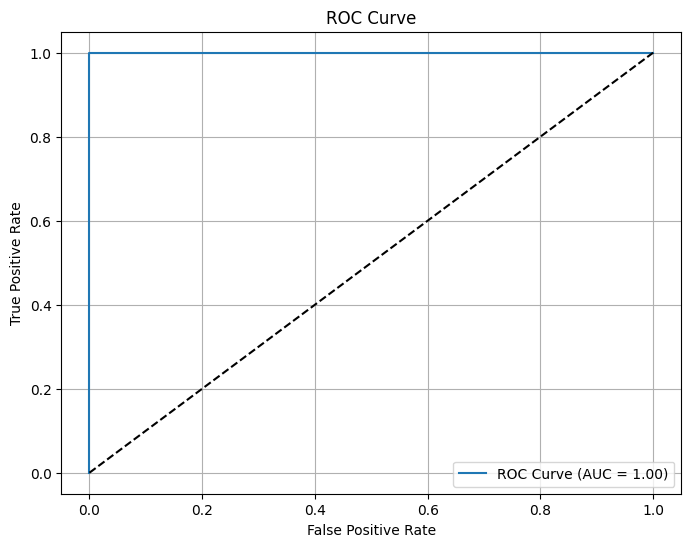

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

batch_size = 32
num_epochs = 20  # Increased epochs
learning_rate = 0.0001  # Reduced learning rate
early_stopping_patience = 5

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=True)

# Freeze early layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify last layer for binary classification
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with early stopping
best_f1 = 0
patience = 0
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Evaluate on the validation set
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, F1 Score: {f1:.2f}')

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        patience = 0
        torch.save(model.state_dict(), 'graphene_classifier_alexnet.pth')  # Save the best model
    else:
        patience += 1
        if patience >= early_stopping_patience:
            print("Early stopping triggered.")
            break

end_time = time.time()
runtime = end_time - start_time

print(f"Best F1 Score: {best_f1:.2f}")
print(f"Total Runtime: {runtime:.2f} seconds")

# Load the best model for evaluation
model.load_state_dict(torch.load('graphene_classifier_alexnet.pth'))

# Evaluate on test set and calculate metrics
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = (all_probs > 0.5).astype(int)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Final Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Confusion Matrix:\n', conf_matrix)

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.grid()
plt.show()

#VGG

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.7MB/s]


Epoch [1/10], Loss: 0.2113, F1 Score: 0.85
Epoch [2/10], Loss: 0.0981, F1 Score: 0.96
Epoch [3/10], Loss: 0.0874, F1 Score: 0.88
Epoch [4/10], Loss: 0.1172, F1 Score: 0.90
Epoch [5/10], Loss: 0.2464, F1 Score: 0.89
Early stopping triggered.
Accuracy: 88.00%
Precision: 0.81
F1 Score: 0.89
ROC AUC: 0.88
Confusion Matrix:
 [[38 12]
 [ 0 50]]


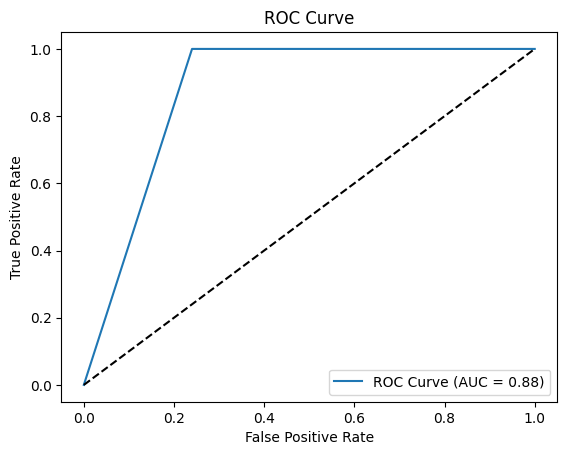

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

batch_size = 32
num_epochs = 10
learning_rate = 0.001
scheduler_step_size = 5
scheduler_gamma = 0.1
early_stopping_patience = 3  # Early Stopping
best_f1 = 0.0
gradient_clipping = 1.0  # Clip gradients to stabilize training

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_counts = np.bincount(train_dataset.targets)
class_weights = torch.tensor([max(class_counts) / c for c in class_counts], dtype=torch.float32).to(device)

# Load pre-trained VGG model
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze convolutional layers
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)  # Binary classification
model = model.to(device)

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.classifier[6].apply(initialize_weights)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Adjust for class imbalance
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, F1 Score: {f1:.2f}')

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        patience = 0
        torch.save(model.state_dict(), 'best_graphene_classifier.pth')
    else:
        patience += 1
        if patience >= early_stopping_patience:
            print("Early stopping triggered.")
            break

model.eval()
all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', conf_matrix)

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

torch.save(model.state_dict(), 'graphene_classifier_vgg16.pth')

#EfficientNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]


Epoch [1/10], Loss: 0.0327
Epoch [2/10], Loss: 0.0147
Epoch [3/10], Loss: 0.0112
Epoch [4/10], Loss: 0.0076
Epoch [5/10], Loss: 0.0050
Epoch [6/10], Loss: 0.0085
Epoch [7/10], Loss: 0.0096
Epoch [8/10], Loss: 0.0101
Epoch [9/10], Loss: 0.0046
Epoch [10/10], Loss: 0.0036
Accuracy: 94.00%
Precision: 0.89
F1 Score: 0.94
ROC AUC: 0.98
Confusion Matrix:
 [[44  6]
 [ 0 50]]
Training Runtime: 362.55 seconds


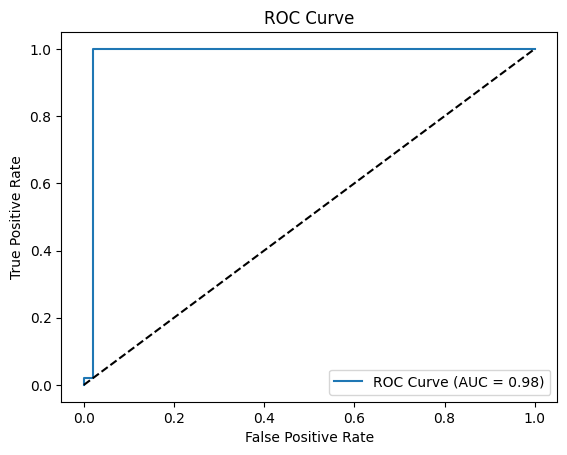

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import time

train_dir = '/content/Dataset/train'
test_dir = '/content/Dataset/test'

batch_size = 32
num_epochs = 10
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the last layer for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_time=time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs.squeeze())
        predicted = (probabilities > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
end_time=time.time()
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', conf_matrix)

runtime = end_time - start_time
print(f'Training Runtime: {runtime:.2f} seconds')

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

torch.save(model.state_dict(), 'graphene_classifier_efficientnet.pth')

#Inception

In [ ]:
!pip cache purge
!pip install --upgrade torch torchvision torchaudio

Files removed: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=I

Epoch 0/9
----------
train Loss: 0.0464 Acc: 0.9855
test Loss: 1.2319 Acc: 0.5000
test Accuracy: 0.5000 Precision: 0.5000 F1 Score: 0.6667 ROC AUC: 0.9952
Confusion Matrix:
 [[ 0 50]
 [ 0 50]]


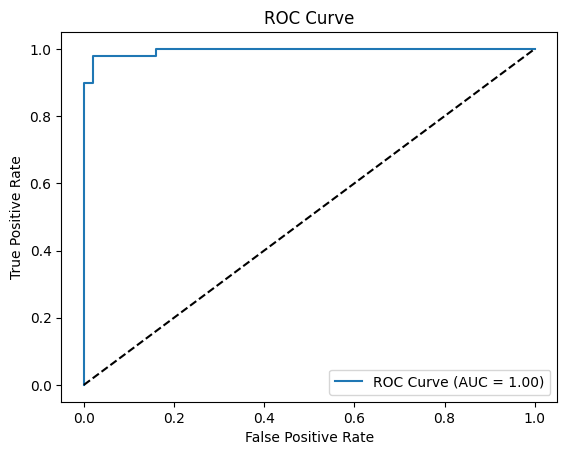

Epoch 1/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0133 Acc: 0.9944
test Loss: 0.6577 Acc: 0.7000
test Accuracy: 0.7000 Precision: 0.6250 F1 Score: 0.7692 ROC AUC: 0.9976
Confusion Matrix:
 [[20 30]
 [ 0 50]]


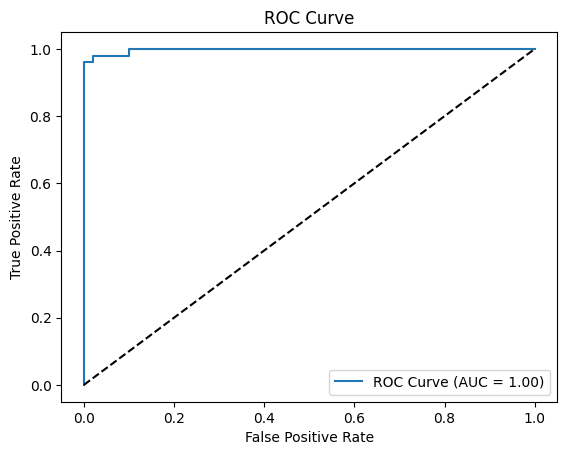

Epoch 2/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0091 Acc: 0.9963
test Loss: 0.5615 Acc: 0.8000
test Accuracy: 0.8000 Precision: 0.7143 F1 Score: 0.8333 ROC AUC: 0.9976
Confusion Matrix:
 [[30 20]
 [ 0 50]]


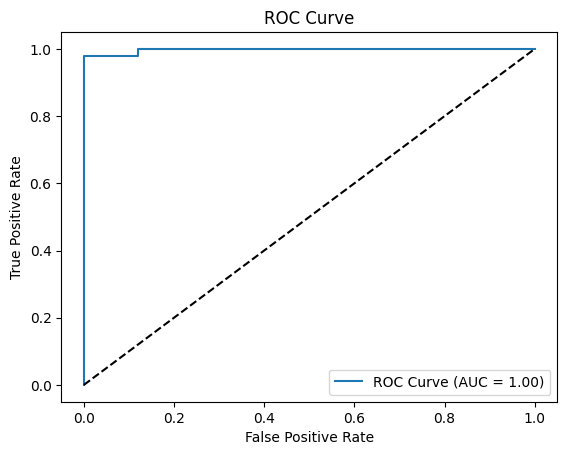

Epoch 3/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0100 Acc: 0.9963
test Loss: 0.4179 Acc: 0.8500
test Accuracy: 0.8500 Precision: 0.7692 F1 Score: 0.8696 ROC AUC: 0.9996
Confusion Matrix:
 [[35 15]
 [ 0 50]]


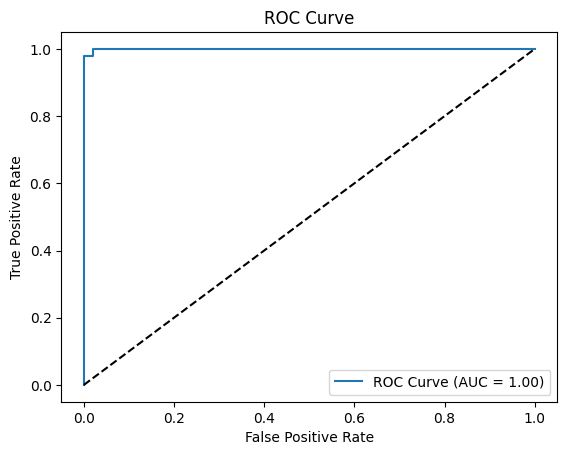

Epoch 4/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0077 Acc: 0.9971
test Loss: 0.3182 Acc: 0.8800
test Accuracy: 0.8800 Precision: 0.8065 F1 Score: 0.8929 ROC AUC: 0.9988
Confusion Matrix:
 [[38 12]
 [ 0 50]]


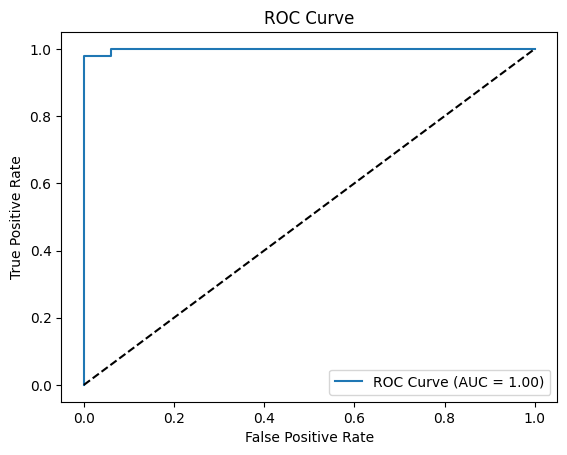

Epoch 5/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0071 Acc: 0.9979
test Loss: 0.4306 Acc: 0.8600
test Accuracy: 0.8600 Precision: 0.7812 F1 Score: 0.8772 ROC AUC: 0.9984
Confusion Matrix:
 [[36 14]
 [ 0 50]]


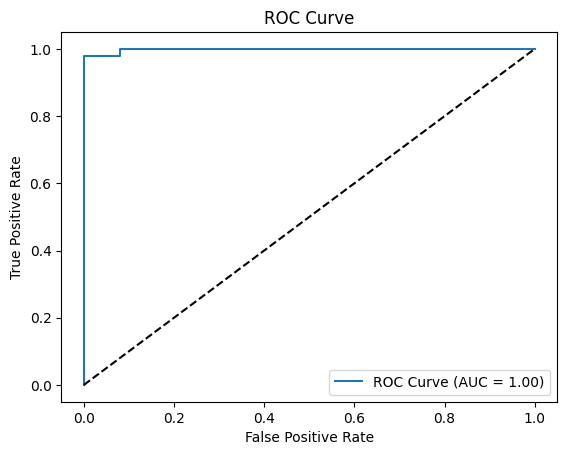

Epoch 6/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0062 Acc: 0.9977
test Loss: 0.3577 Acc: 0.8800
test Accuracy: 0.8800 Precision: 0.8065 F1 Score: 0.8929 ROC AUC: 0.9980
Confusion Matrix:
 [[38 12]
 [ 0 50]]


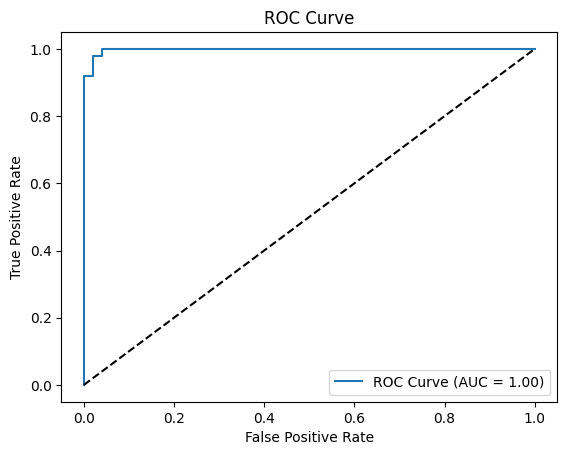

Epoch 7/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0089 Acc: 0.9969
test Loss: 0.3213 Acc: 0.8900
test Accuracy: 0.8900 Precision: 0.8197 F1 Score: 0.9009 ROC AUC: 0.9988
Confusion Matrix:
 [[39 11]
 [ 0 50]]


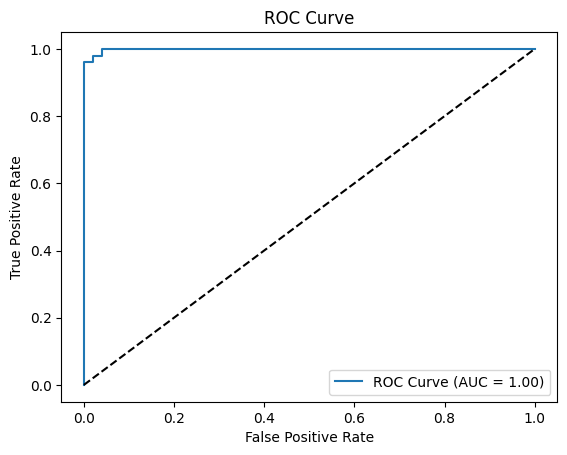

Epoch 8/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0080 Acc: 0.9973
test Loss: 0.3521 Acc: 0.8700
test Accuracy: 0.8700 Precision: 0.7937 F1 Score: 0.8850 ROC AUC: 0.9988
Confusion Matrix:
 [[37 13]
 [ 0 50]]


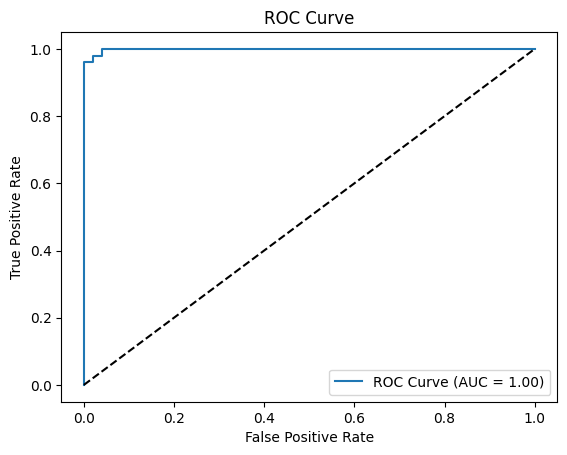

Epoch 9/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.0050 Acc: 0.9983
test Loss: 0.2719 Acc: 0.9100
test Accuracy: 0.9100 Precision: 0.8475 F1 Score: 0.9174 ROC AUC: 0.9988
Confusion Matrix:
 [[41  9]
 [ 0 50]]


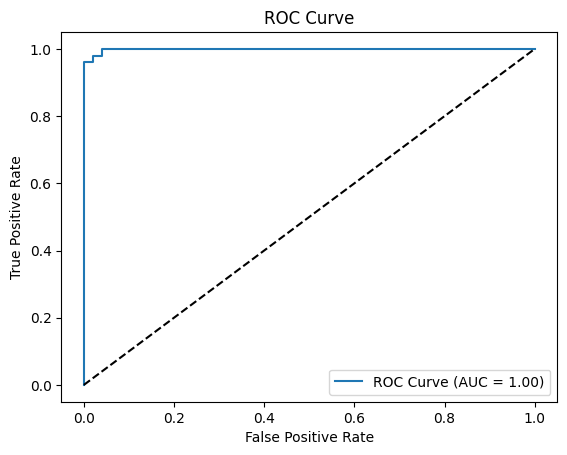

Training Runtime: 706.03 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import os
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = '/content/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Load a pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes for binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
time_start=time.time()
# Training function with metrics calculation
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                    else:
                        outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            if phase == 'test':
                accuracy = accuracy_score(all_labels, all_preds)
                precision = precision_score(all_labels, all_preds, average='binary')
                f1 = f1_score(all_labels, all_preds, average='binary')
                roc_auc = roc_auc_score(all_labels, all_probs)

                print(f'{phase} Accuracy: {accuracy:.4f} Precision: {precision:.4f} F1 Score: {f1:.4f} ROC AUC: {roc_auc:.4f}')

                conf_matrix = confusion_matrix(all_labels, all_preds)
                print('Confusion Matrix:\n', conf_matrix)

                fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
                plt.figure()
                plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve')
                plt.legend(loc="best")
                plt.show()

    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
end_time=time.time()
runtime = end_time - time_start
print(f'Training Runtime: {runtime:.2f} seconds')
torch.save(model.state_dict(), 'graphene_classifier_inception.pth')

#Test Models on Individual Images

##Test AlexNet on Chosen Image

Path to Image: /content/graphene.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-18-4a8a252ce8b7>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

The image is classified as: Graphene Flake (Probability: 0.9966)


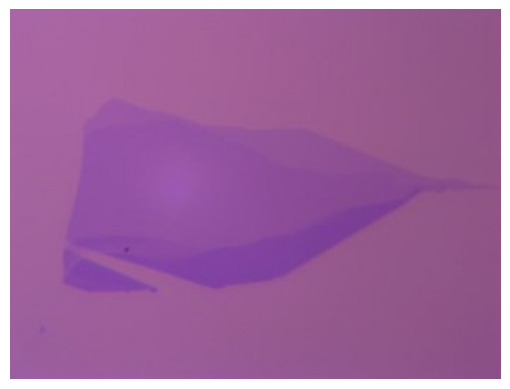

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_alexnet.pth'
image_path =  input("Path to Image: ")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.sigmoid(output).item()

if prediction > 0.5:
    print(f'The image is classified as: Graphene Flake (Probability: {prediction:.4f})')
else:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {1-prediction:.4f})')

plt.imshow(image)
plt.axis('off')
plt.show()

##Test ResNet on Chosen Image

Path to Image: /content/graphene.jpg


<ipython-input-10-9ef67e304b79>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


The image is classified as: Graphene Flake (Probability: 0.6902)


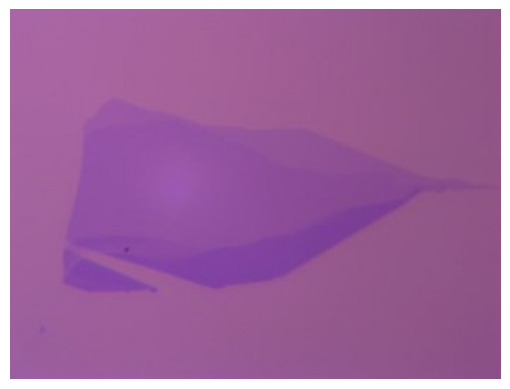

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_resnet.pth'
image_path =  input("Path to Image: ")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    image = Image.open(image_path).convert('RGB')
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.sigmoid(output).item()

if prediction < 0.5:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {1-prediction:.4f})')
else:
    print(f'The image is classified as: Graphene Flake (Probability: {prediction:.4f})')

plt.imshow(image)
plt.axis('off')
plt.show()

##Test VGG on Chosen Image

Path to Image: /content/graphene.jpg


<ipython-input-13-695e7b945f86>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


The image is classified as: Graphene Flake (Probability: 0.8876)


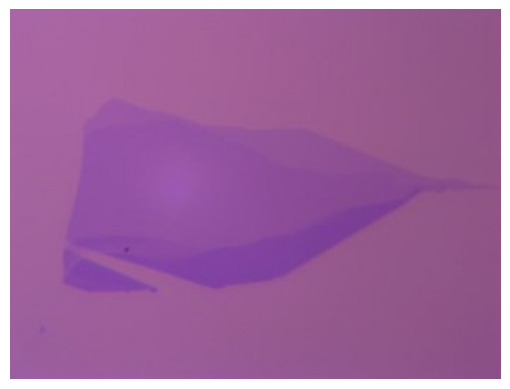

In [13]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_vgg16.pth'
image_path =  input("Path to Image: ")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.sigmoid(output).item()

if prediction > 0.5:
    print(f'The image is classified as: Graphene Flake (Probability: {prediction:.4f})')
else:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {1-prediction:.4f})')

plt.imshow(image)
plt.axis('off')
plt.show()

##Test EfficientNet on Chosen Image

Path to Image: /content/graphene.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-19-497c68774c38>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

The image is classified as: Graphene Flake (Probability: 0.9713)


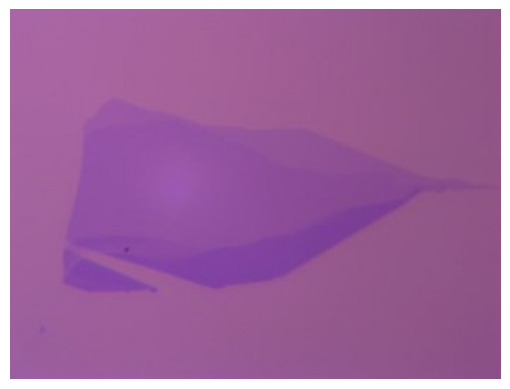

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image

# Define the path to the saved model and the image to classify
model_path = 'graphene_classifier_efficientnet.pth'
image_path =  input("Path to Image: ")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.sigmoid(output).item()

if prediction < 0.5:
    print(f'The image is classified as: Graphene Flake (Probability: {1-prediction:.4f})')
else:
    print(f'The image is classified as: Not a Graphene Flake (Probability: {prediction:.4f})')

plt.imshow(image)
plt.axis('off')
plt.show()

##Test Inception on Chosen Image

<ipython-input-21-3645ea8cfa59>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Path to Image: /content/graphene.jpg


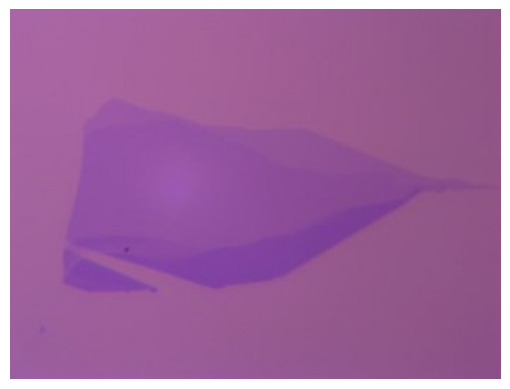

Predicted: Graphene


In [21]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved InceptionV3 model
model_path = '/content/graphene_classifier_inception.pth'
model = models.inception_v3(pretrained=False)
model.aux_logits = False

num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img_t = preprocess(img)
        batch_t = img_t.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(batch_t)

        _, predicted_class = torch.max(output, 1)

        labels = ["Graphene", "Not Graphene"]
        label = labels[predicted_class.item()]

        print(f'Predicted: {label}')
    except Exception as e:
        print(f"Error: {e}")

image_path = input("Path to Image: ")

predict_image(image_path)